In [1]:
# Python Notebook for Adversarial Patch Attack
%load_ext autoreload
%autoreload 2
import os
import hydra
import torch
from omegaconf import OmegaConf
import pathlib
from torch.utils.data import DataLoader
import copy
import random
import dill
import wandb
import tqdm
import numpy as np
import shutil
import collections
from diffusion_policy.workspace.base_workspace import BaseWorkspace
from diffusion_policy.policy.robomimic_image_policy import RobomimicImagePolicy
from diffusion_policy.dataset.base_dataset import BaseImageDataset
from diffusion_policy.dataset.robomimic_replay_image_dataset import RobomimicReplayImageDataset
from diffusion_policy.env_runner.base_image_runner import BaseImageRunner
from diffusion_policy.common.checkpoint_util import TopKCheckpointManager
from diffusion_policy.common.json_logger import JsonLogger
from diffusion_policy.common.pytorch_util import dict_apply, optimizer_to
from diffusion_policy.workspace.train_robomimic_image_workspace import TrainRobomimicImageWorkspace
from diffusion_policy.utils.attack_utils import transform_square_patch

/home/zeus/miniconda3/envs/cloudspace/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import robomimic.utils.env_utils as EnvUtils
import robomimic.utils.obs_utils as ObsUtils
import robomimic.utils.file_utils as FileUtils

def create_env(env_meta, shape_meta, enable_render=True):
    modality_mapping = collections.defaultdict(list)
    for key, attr in shape_meta['obs'].items():
        modality_mapping[attr.get('type', 'low_dim')].append(key)
    ObsUtils.initialize_obs_modality_mapping_from_dict(modality_mapping)
    print(env_meta)

    env = EnvUtils.create_env_from_metadata(
        env_meta=env_meta,
        render=False, 
        render_offscreen=enable_render,
        use_image_obs=enable_render, 
    )
    return env

In [3]:
checkpoint = '/teamspace/studios/this_studio/bc_attacks/diffusion_policy/data/experiments/image/lift_ph/ibc_dfo/train_2/checkpoints/epoch=2100-test_mean_score=1.000.ckpt'
# checkpoint = '/teamspace/studios/this_studio/bc_attacks/diffusion_policy/data/experiments/low_dim/lift_ph/lstm_gmm/train_0/checkpoints/epoch=0600-test_mean_score=1.000.ckpt'
payload = torch.load(open(checkpoint, 'rb'), pickle_module=dill)
cfg_loaded = payload['cfg']
cls = hydra.utils.get_class(cfg_loaded._target_)
workspace = cls(cfg_loaded)
workspace.load_payload(payload, exclude_keys=None, include_keys=None)
policy = workspace.model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
policy.to(device)
policy.eval()

cfg_loaded.task.env_runner['_target_'] = 'diffusion_policy.env_runner.robomimic_single_image_runner.RobomimicSingleImageRunner'
# cfg_loaded.task.env_runner['_target_'] = 'diffusion_policy.env_runner.robomimic_lowdim_runner.RobomimicLowDimRunner'
cfg_loaded.task.env_runner.dataset_path = os.path.join('/teamspace/studios/this_studio/bc_attacks/diffusion_policy', cfg_loaded.task.dataset_path)
env_runner = hydra.utils.instantiate(
    cfg_loaded.task.env_runner,
    output_dir=None
)
env = env_runner.env



============= Initialized Observation Utils with Obs Spec =============

using obs modality: low_dim with keys: ['robot0_eef_quat', 'robot0_eef_pos', 'robot0_gripper_qpos']
using obs modality: rgb with keys: ['agentview_image', 'robot0_eye_in_hand_image']
using obs modality: depth with keys: []
using obs modality: scan with keys: []


/home/zeus/miniconda3/envs/cloudspace/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


{'env_name': 'Lift', 'type': 1, 'env_kwargs': {'has_renderer': False, 'has_offscreen_renderer': True, 'ignore_done': True, 'use_object_obs': False, 'use_camera_obs': True, 'control_freq': 20, 'controller_configs': {'type': 'OSC_POSE', 'input_max': 1, 'input_min': -1, 'output_max': [0.05, 0.05, 0.05, 0.5, 0.5, 0.5], 'output_min': [-0.05, -0.05, -0.05, -0.5, -0.5, -0.5], 'kp': 150, 'damping': 1, 'impedance_mode': 'fixed', 'kp_limits': [0, 300], 'damping_limits': [0, 10], 'position_limits': None, 'orientation_limits': None, 'uncouple_pos_ori': True, 'control_delta': True, 'interpolation': None, 'ramp_ratio': 0.2}, 'robots': ['Panda'], 'camera_depths': False, 'camera_heights': 84, 'camera_widths': 84, 'reward_shaping': False, 'camera_names': ['agentview', 'robot0_eye_in_hand'], 'render_gpu_device_id': 0}}
Created environment with name Lift
Action size is 7


In [4]:
# collect observations and actions for the policy for one rollout
import tqdm
obs = env.reset()
obs_list = []
action_list = []
done = False
timestep = 0
max_timesteps = 30
eye_in_hand_images = []
agentview_images = []
objects = []
for i in range(10):
    obs = env.reset()
    done = False
    with tqdm.tqdm(total=max_timesteps, desc="Timesteps") as pbar:
        timestep = 0
        while not done and timestep < max_timesteps:
            np_obs_dict = dict(obs)
            # save the eye in hand images
            eye_in_hand_images.append(np_obs_dict['robot0_eye_in_hand_image'])
            agentview_images.append(np_obs_dict['agentview_image'])
            obs_dict = dict_apply(np_obs_dict, lambda x: torch.tensor(x).unsqueeze(0).to(device))
            obs_list.append(obs_dict)
            objects.append(env.env.env.get_observation()['object'])
            action = policy.predict_action(obs_dict)['action'].squeeze(0).cpu().numpy()
            action_list.append(action)
            obs, _, done, _ = env.step(action)
            timestep += 1
            pbar.update(1)


Timesteps: 100%|██████████| 30/30 [00:07<00:00,  4.08it/s]


In [5]:
# squeeze the obs to shape (3, size, size)
obs_list = [dict_apply(obs, lambda x: x.squeeze(0)) for obs in obs_list]

In [41]:
single_image = eye_in_hand_images[0][0]
top_left_rgb = single_image[:, 0, 0]

def remove_red_patch(image):
    image_ = np.copy(image)
    image_ = image_.transpose(1, 2, 0)
    red = np.array([1, 0, 0])
    mask = np.all(np.abs(image_ - red) < 0.5, axis=-1)
    # find the red block center
    x, y = np.where(mask)
    if len(x) == 0:
        print("No red block found")
        return image_
    x, y = np.mean(x).astype(int), np.mean(y).astype(int)
    patch = np.zeros((28, 28, 3))
    patch[:, :] = top_left_rgb
    if x-14 < 0 or y-14 < 0 or x+14 >= image_.shape[0] or y+14 >= image_.shape[1]:
        print("Red block is too close to the edge")
        return image_
    image_[x-14:x+14, y-14:y+14] = patch
    return image_
    
def remove_red_patch_batch(images):
    # the images will be of shape (B, N, C, H, W)
    images_ = torch.tensor(images).cpu().numpy()
    for i in range(images_.shape[0]):
            images_[i] = remove_red_patch(images_[i]).transpose(2, 0, 1)
    images_ = torch.tensor(images_, device=device)
    return images_

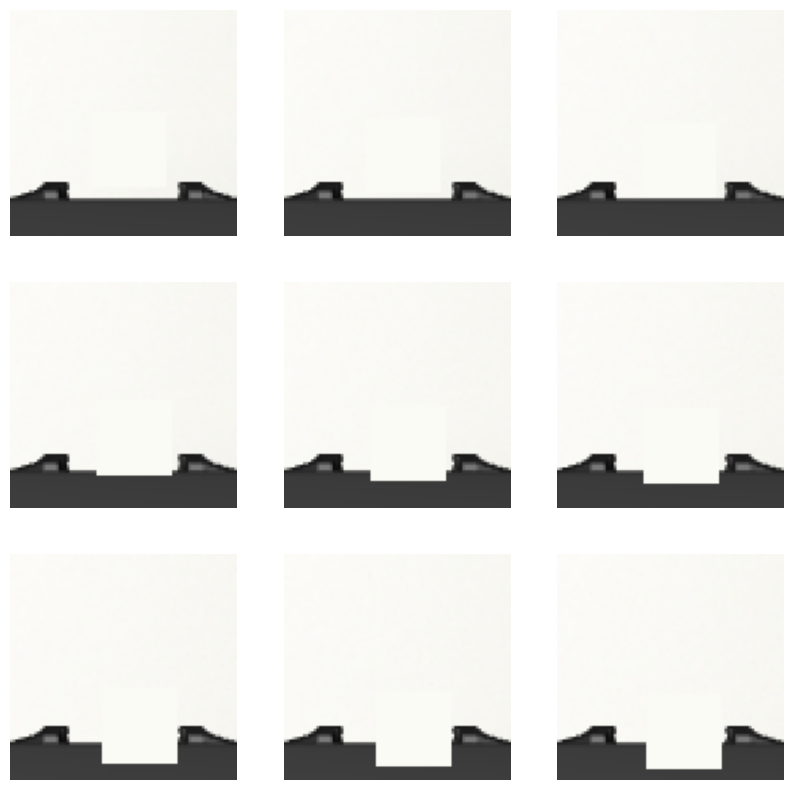

In [14]:
# for the images in the eye_in_hand_images and agentview_images 
# remove the red block and replace it with the background
# and save the images
no_red_eye_in_hand_images = []
no_red_agentview_images = []
single_image = eye_in_hand_images[0][0]
top_left_rgb = single_image[:, 0, 0]

for image in eye_in_hand_images:
    # remove the red color from the image
    image_ = remove_red_patch(image[0])
    no_red_eye_in_hand_images.append(image_)
# show some of the images
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(no_red_eye_in_hand_images[i+20])
    plt.axis('off')
plt.show()

In [127]:
# save the observations and actions as pkl file for loading later
import pickle
obs_actions = {'obs': obs_list, 'actions': action_list}
file_path = '/teamspace/studios/this_studio/bc_attacks/diffusion_policy/plots/pkl_files/ibc_dfo_train0_obs_actions.pkl'
with open(file_path, 'wb') as f:
     pickle.dump(obs_actions, f)
file_path = '/teamspace/studios/this_studio/bc_attacks/diffusion_policy/plots/pkl_files/ibc_eye_in_hand_images.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(eye_in_hand_images, f)
file_path = '/teamspace/studios/this_studio/bc_attacks/diffusion_policy/plots/pkl_files/ibc_objects.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(objects, f)
file_path = '/teamspace/studios/this_studio/bc_attacks/diffusion_policy/plots/pkl_files/ibc_no_red_eye_in_hand_images.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(no_red_eye_in_hand_images, f)
print(f"Observations and actions saved to {file_path}")

Observations and actions saved to /teamspace/studios/this_studio/bc_attacks/diffusion_policy/plots/pkl_files/ibc_no_red_eye_in_hand_images.pkl


In [4]:
# load the observations and actions from the pkl file
import pickle
file_path = '/teamspace/studios/this_studio/bc_attacks/diffusion_policy/plots/pkl_files/ibc_dfo_train0_obs_actions.pkl'
if os.path.exists(file_path):
    with open(file_path, 'rb') as f:
        obs_actions = pickle.load(f)
    obs_list = obs_actions['obs']
    action_list = obs_actions['actions']
    print(f"Observations and actions loaded from {file_path}")

Observations and actions loaded from /teamspace/studios/this_studio/bc_attacks/diffusion_policy/plots/pkl_files/ibc_dfo_train0_obs_actions.pkl


In [12]:
print(env.env.env.get_observation()['object'])

[ 0.00989107  0.02176046  0.83129282  0.          0.          0.45076306
  0.89264364 -0.11880777 -0.04512027  0.17286327]


ValueError: axes don't match array

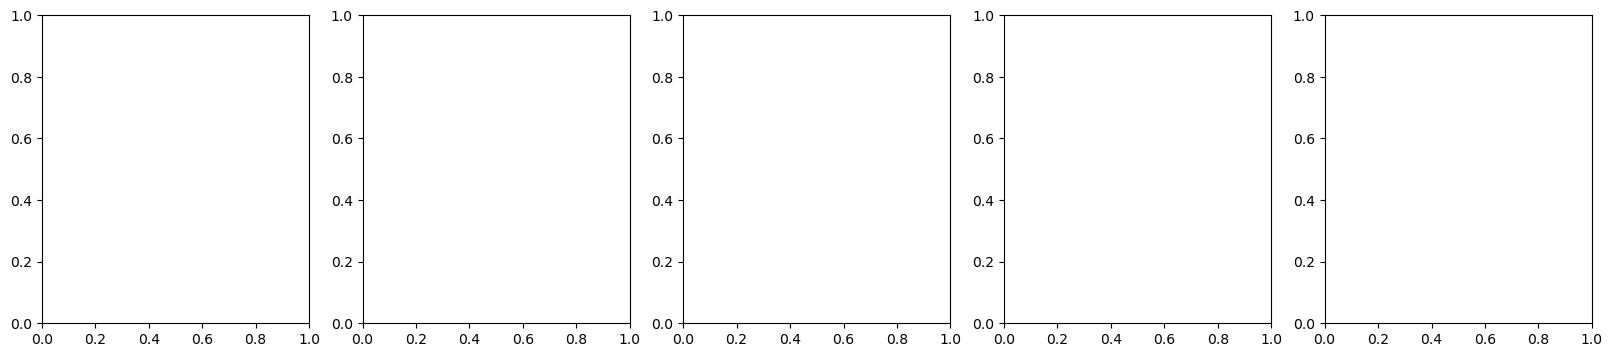

In [8]:
# visualize few of the agentview_image observations
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i in range(1, 5):
    obs = obs_list[i].copy()
    agentview_image = obs['agentview_image'].squeeze(0).cpu().detach().numpy()
    agentview_image = np.transpose(agentview_image, (1, 2, 0))
    axes[i].imshow(agentview_image)
    axes[i].axis('off')
plt.show()


In [15]:
# add perturbations to the actions
perturbations = np.array([0., 0., 0.15, 0., 0, 0, 0])
target_action_list = []
for i in range(len(action_list)):
    target_action = action_list[i] + perturbations
    # target action to close the gripper always
    # target_action[-1] = 1
    target_action_list.append(target_action)

In [16]:
def place_patch(image, patch, location=(0, 0)):
    # image: (B, n_obs, 3, size, size)
    # patch: (3, patch_size, patch_size)
    # location: (x, y)
    original_len = len(image.shape)
    if original_len == 4:
        image = image.unsqueeze(0)
    x, y = location
    image[:, :, :, x:x+patch.shape[1], y:y+patch.shape[2]] = patch_forward(patch)
    if original_len == 4:
        image = image.squeeze(0)
    return image

def patch_forward(patch):
    # applies tanh to the patch and scales it to [0, 1]
    # patch = torch.tanh(patch) / 2 + 0.5
    return 0.125 * torch.tanh(patch)

def place_transparent_patch(image, patch, location=(0, 0)):
    # image: (B, n_obs, 3, size, size)
    # patch: (3, patch_size, patch_size)
    # location: (x, y)
    original_len = len(image.shape)
    if original_len == 4:
        image = image.unsqueeze(0)
    x, y = location
    patch = patch_forward(patch)
    # image[:, :, :, x:x+patch.shape[1], y:y+patch.shape[2]] = patch_alpha * patch[:3] + (1 - patch_alpha) * image[:, :, :, x:x+patch.shape[1], y:y+patch.shape[2]]
    image[:, :, :, :, :] = image[:, :, :, :, :] + patch[:3]
    if original_len == 4:
        image = image.squeeze(0)
    return image

# visualize the patch
# patch_ = torch.zeros((3, 32, 32))
# image_ = obs_list[0]['robot0_eye_in_hand_image'].clone()
# image_ = place_patch(image_, patch_, location=(24, 24))
# image_ = image_.squeeze(0).cpu().detach().numpy()
# image_ = np.transpose(image_, (1, 2, 0))
# plt.imshow(image_)
# plt.axis('off')
# plt.show()

In [20]:
x_loc, y_loc = 16, 16
patch_size = 16

In [42]:
# evaluate the patch
view = 'robot0_eye_in_hand_image'
# view = 'agentview_image'
def evaluate_patch(patch, transparent=False, remove_red=False):
    patch_cp = patch.clone().detach()
    obs = env.reset()
    policy.reset()
    obs = dict_apply(obs, lambda x: torch.tensor(x).to(device))
    print(obs[view].shape)
    if transparent:
        obs[view] = place_transparent_patch(obs[view], patch_cp, location=(0, 0))
    elif remove_red:
        obs[view] = remove_red_patch_batch(obs[view])
    else:
        obs[view] = place_patch(obs[view], patch_cp,location=(x_loc, y_loc))
    # convert to tensor
    obs = dict_apply(obs, lambda x: torch.tensor(x).unsqueeze(0))
    done = False
    max_timesteps = 400
    rewards = 0
    obs_agentview = []
    obs_robot0_eye_in_hand = []
    with tqdm.tqdm(total=max_timesteps, desc="Timesteps") as pbar:
        timestep = 0
        while not done and timestep < max_timesteps:
            # for key in obs.keys():
            #    print(key, obs[key].shape)
            action_dict = policy.predict_action(obs)
            action = action_dict['action'].cpu().detach().numpy().squeeze(0)
            obs, reward, done, _ = env.step(action)
            obs = dict_apply(obs, lambda x: torch.tensor(x).to(device))
            if transparent:
                obs[view] = place_transparent_patch(obs[view], patch_cp, location=(0, 0))
            elif remove_red:
                obs[view] = remove_red_patch_batch(obs[view])
            else:
                obs[view] = place_patch(obs[view], patch_cp, location=(x_loc, y_loc))
            # obs = dict_apply(obs, lambda x: x.squeeze(0))
            obs = dict_apply(obs, lambda x: torch.tensor(x).unsqueeze(0))
            obs_agentview.append(obs['agentview_image'])
            obs_robot0_eye_in_hand.append(obs['robot0_eye_in_hand_image'])
            timestep += 1
            pbar.update(1)
            rewards += reward
        if rewards > 0:
            print(f"Patch is unsuccessful with reward: {rewards}")
        elif rewards == 0:
            print(f"Patch is successful with reward: {rewards}")
        else:
            pass
    return rewards, obs_agentview, obs_robot0_eye_in_hand

# test the evaluate_patch function
patch = torch.zeros((3, patch_size, patch_size))
red_patch = torch.zeros((3, patch_size, patch_size))
red_patch[0] = 1
rewards, observation_agentview, observation_robot0_eye_in_hand = evaluate_patch(red_patch, remove_red=True)
# print(rewards)


/tmp/ipykernel_7744/620042962.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images_ = torch.tensor(images).cpu().numpy()
/tmp/ipykernel_7744/357309091.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs = dict_apply(obs, lambda x: torch.tensor(x).unsqueeze(0))


torch.Size([2, 3, 84, 84])


Timesteps:   0%|          | 0/400 [00:00<?, ?it/s]/tmp/ipykernel_7744/357309091.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs = dict_apply(obs, lambda x: torch.tensor(x).unsqueeze(0))
Timesteps:  22%|██▏       | 87/400 [00:12<00:45,  6.95it/s]

Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge


Timesteps:  22%|██▏       | 89/400 [00:13<00:44,  6.94it/s]

Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge


Timesteps:  23%|██▎       | 91/400 [00:13<00:44,  6.91it/s]

Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge


Timesteps:  23%|██▎       | 93/400 [00:13<00:44,  6.91it/s]

Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge


Timesteps:  24%|██▍       | 95/400 [00:14<00:43,  6.93it/s]

Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge


Timesteps:  24%|██▍       | 97/400 [00:14<00:43,  6.95it/s]

Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge


Timesteps:  25%|██▍       | 99/400 [00:14<00:43,  6.98it/s]

Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge


Timesteps:  25%|██▌       | 101/400 [00:14<00:42,  6.99it/s]

Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge


Timesteps:  26%|██▌       | 103/400 [00:15<00:42,  7.01it/s]

Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge


Timesteps:  26%|██▋       | 105/400 [00:15<00:42,  7.01it/s]

Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge


Timesteps:  27%|██▋       | 107/400 [00:15<00:41,  7.04it/s]

Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge


Timesteps:  27%|██▋       | 109/400 [00:16<00:41,  7.03it/s]

Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge


Timesteps:  28%|██▊       | 111/400 [00:16<00:40,  7.06it/s]

Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge


Timesteps:  28%|██▊       | 113/400 [00:16<00:40,  7.11it/s]

Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge


Timesteps:  29%|██▉       | 115/400 [00:16<00:40,  7.08it/s]

Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge


Timesteps:  29%|██▉       | 117/400 [00:17<00:39,  7.08it/s]

Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge


Timesteps:  30%|██▉       | 119/400 [00:17<00:39,  7.03it/s]

Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge


Timesteps:  30%|███       | 121/400 [00:17<00:39,  7.09it/s]

Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge


Timesteps:  31%|███       | 123/400 [00:18<00:38,  7.13it/s]

Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge


Timesteps:  31%|███▏      | 125/400 [00:18<00:38,  7.10it/s]

Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge


Timesteps:  32%|███▏      | 127/400 [00:18<00:38,  7.15it/s]

Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge


Timesteps:  32%|███▏      | 129/400 [00:18<00:37,  7.19it/s]

Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge


Timesteps:  33%|███▎      | 131/400 [00:19<00:37,  7.21it/s]

Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge


Timesteps:  33%|███▎      | 133/400 [00:19<00:36,  7.23it/s]

Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge


Timesteps:  34%|███▍      | 135/400 [00:19<00:36,  7.22it/s]

Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge


Timesteps:  34%|███▍      | 137/400 [00:19<00:36,  7.24it/s]

Red block is too close to the edge
No red block found
No red block found
Red block is too close to the edge


Timesteps:  35%|███▍      | 139/400 [00:20<00:36,  7.18it/s]

Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge


Timesteps:  35%|███▌      | 141/400 [00:20<00:35,  7.20it/s]

Red block is too close to the edge
Red block is too close to the edge
No red block found


Timesteps:  36%|███▌      | 143/400 [00:20<00:35,  7.25it/s]

No red block found
Red block is too close to the edge
Red block is too close to the edge


Timesteps:  37%|███▋      | 147/400 [00:21<00:35,  7.22it/s]

Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge


Timesteps:  37%|███▋      | 149/400 [00:21<00:34,  7.24it/s]

Red block is too close to the edge
No red block found


Timesteps:  38%|███▊      | 151/400 [00:21<00:34,  7.26it/s]

No red block found
No red block found


Timesteps:  38%|███▊      | 153/400 [00:22<00:33,  7.27it/s]

No red block found
No red block found
No red block found
Red block is too close to the edge


Timesteps:  39%|███▉      | 155/400 [00:22<00:33,  7.29it/s]

Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge


Timesteps:  39%|███▉      | 157/400 [00:22<00:33,  7.31it/s]

Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge


Timesteps:  40%|███▉      | 159/400 [00:23<00:33,  7.30it/s]

Red block is too close to the edge
No red block found
No red block found
No red block found


Timesteps:  40%|████      | 161/400 [00:23<00:32,  7.27it/s]

No red block found
Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge


Timesteps:  41%|████      | 163/400 [00:23<00:32,  7.26it/s]

Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge


Timesteps:  41%|████▏     | 165/400 [00:23<00:32,  7.22it/s]

Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge
No red block found


Timesteps:  42%|████▏     | 167/400 [00:24<00:32,  7.20it/s]

No red block found
No red block found
No red block found
Red block is too close to the edge


Timesteps:  42%|████▏     | 169/400 [00:24<00:32,  7.21it/s]

Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge


Timesteps:  43%|████▎     | 171/400 [00:24<00:31,  7.18it/s]

Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge


Timesteps:  43%|████▎     | 173/400 [00:24<00:31,  7.11it/s]

Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge


Timesteps:  44%|████▍     | 175/400 [00:25<00:31,  7.10it/s]

Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge


Timesteps:  44%|████▍     | 177/400 [00:25<00:31,  7.08it/s]

Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge


Timesteps:  45%|████▍     | 179/400 [00:25<00:31,  7.09it/s]

Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge
No red block found


Timesteps:  45%|████▌     | 181/400 [00:26<00:30,  7.11it/s]

No red block found
Red block is too close to the edge
Red block is too close to the edge
No red block found


Timesteps:  46%|████▌     | 183/400 [00:26<00:30,  7.11it/s]

No red block found
Red block is too close to the edge


Timesteps:  46%|████▋     | 185/400 [00:26<00:30,  7.14it/s]

Red block is too close to the edge
No red block found
No red block found
No red block found


Timesteps:  47%|████▋     | 187/400 [00:26<00:29,  7.15it/s]

No red block found
No red block found
No red block found
No red block found


Timesteps:  47%|████▋     | 189/400 [00:27<00:29,  7.15it/s]

No red block found
No red block found
No red block found
No red block found


Timesteps:  48%|████▊     | 191/400 [00:27<00:29,  7.01it/s]

No red block found
No red block found
No red block found
No red block found


Timesteps:  48%|████▊     | 193/400 [00:27<00:29,  7.08it/s]

No red block found
No red block found
No red block found
No red block found


Timesteps:  49%|████▉     | 195/400 [00:28<00:28,  7.08it/s]

No red block found
No red block found
No red block found
No red block found


Timesteps:  49%|████▉     | 197/400 [00:28<00:28,  7.06it/s]

No red block found
No red block found
No red block found
No red block found


Timesteps:  50%|████▉     | 199/400 [00:28<00:28,  7.12it/s]

No red block found
No red block found
No red block found
No red block found


Timesteps:  50%|█████     | 201/400 [00:28<00:27,  7.15it/s]

No red block found
No red block found
No red block found
No red block found


Timesteps:  51%|█████     | 203/400 [00:29<00:27,  7.15it/s]

No red block found
No red block found
No red block found
No red block found


Timesteps:  51%|█████▏    | 205/400 [00:29<00:27,  7.16it/s]

No red block found
No red block found
No red block found
No red block found


Timesteps:  52%|█████▏    | 207/400 [00:29<00:26,  7.17it/s]

No red block found
No red block found
No red block found
No red block found


Timesteps:  52%|█████▏    | 209/400 [00:30<00:26,  7.17it/s]

No red block found
No red block found
No red block found
No red block found


Timesteps:  53%|█████▎    | 211/400 [00:30<00:26,  7.18it/s]

No red block found
No red block found
No red block found
No red block found


Timesteps:  53%|█████▎    | 213/400 [00:30<00:25,  7.20it/s]

No red block found
No red block found
No red block found
No red block found


Timesteps:  54%|█████▍    | 215/400 [00:30<00:25,  7.22it/s]

No red block found
No red block found
No red block found
No red block found


Timesteps:  54%|█████▍    | 217/400 [00:31<00:29,  6.18it/s]

No red block found
No red block found
No red block found
No red block found


Timesteps:  55%|█████▍    | 219/400 [00:31<00:31,  5.79it/s]

No red block found
No red block found
No red block found
No red block found


Timesteps:  55%|█████▌    | 221/400 [00:31<00:31,  5.61it/s]

No red block found
No red block found
No red block found
No red block found


Timesteps:  56%|█████▌    | 223/400 [00:32<00:32,  5.37it/s]

No red block found
No red block found
No red block found
Red block is too close to the edge


Timesteps:  56%|█████▋    | 225/400 [00:32<00:28,  6.08it/s]

Red block is too close to the edge
No red block found
No red block found
Red block is too close to the edge


Timesteps:  57%|█████▋    | 227/400 [00:32<00:26,  6.62it/s]

Red block is too close to the edge


Timesteps:  57%|█████▊    | 230/400 [00:33<00:24,  7.00it/s]

No red block found
No red block found
No red block found


Timesteps:  58%|█████▊    | 232/400 [00:33<00:23,  7.11it/s]

No red block found
Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge


Timesteps:  58%|█████▊    | 234/400 [00:33<00:23,  7.12it/s]

Red block is too close to the edge
No red block found
No red block found
No red block found


Timesteps:  59%|█████▉    | 236/400 [00:34<00:22,  7.16it/s]

No red block found
Red block is too close to the edge
Red block is too close to the edge
No red block found


Timesteps:  60%|█████▉    | 238/400 [00:34<00:22,  7.23it/s]

No red block found
No red block found
No red block found
No red block found


Timesteps:  60%|██████    | 240/400 [00:34<00:21,  7.28it/s]

No red block found
Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge


Timesteps:  60%|██████    | 242/400 [00:35<00:21,  7.29it/s]

Red block is too close to the edge
No red block found


Timesteps:  61%|██████    | 244/400 [00:35<00:21,  7.29it/s]

No red block found
No red block found
No red block found
No red block found


Timesteps:  62%|██████▏   | 246/400 [00:35<00:21,  7.21it/s]

No red block found
No red block found
No red block found
Red block is too close to the edge


Timesteps:  62%|██████▏   | 248/400 [00:35<00:20,  7.26it/s]

Red block is too close to the edge
No red block found
No red block found
Red block is too close to the edge


Timesteps:  62%|██████▎   | 250/400 [00:36<00:20,  7.26it/s]

Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge
No red block found


Timesteps:  63%|██████▎   | 252/400 [00:36<00:20,  7.25it/s]

No red block found
No red block found
No red block found
No red block found


Timesteps:  64%|██████▎   | 254/400 [00:36<00:20,  7.24it/s]

No red block found
No red block found


Timesteps:  64%|██████▍   | 256/400 [00:36<00:20,  7.16it/s]

No red block found
No red block found
No red block found
No red block found


Timesteps:  64%|██████▍   | 258/400 [00:37<00:19,  7.15it/s]

No red block found
No red block found
No red block found
No red block found


Timesteps:  65%|██████▌   | 260/400 [00:37<00:19,  7.18it/s]

No red block found
No red block found


Timesteps:  66%|██████▌   | 262/400 [00:37<00:19,  7.20it/s]

No red block found
No red block found
No red block found
No red block found


Timesteps:  66%|██████▌   | 264/400 [00:38<00:18,  7.21it/s]

No red block found
No red block found
No red block found
No red block found


Timesteps:  66%|██████▋   | 266/400 [00:38<00:18,  7.17it/s]

No red block found
No red block found
No red block found
No red block found


Timesteps:  67%|██████▋   | 268/400 [00:38<00:18,  7.16it/s]

No red block found
No red block found
No red block found
No red block found


Timesteps:  68%|██████▊   | 270/400 [00:38<00:18,  7.09it/s]

No red block found
No red block found
No red block found
No red block found


Timesteps:  68%|██████▊   | 272/400 [00:39<00:18,  7.09it/s]

No red block found
No red block found
No red block found
No red block found


Timesteps:  68%|██████▊   | 274/400 [00:39<00:17,  7.11it/s]

No red block found
No red block found
No red block found
No red block found


Timesteps:  69%|██████▉   | 276/400 [00:39<00:17,  7.10it/s]

No red block found
No red block found
No red block found
No red block found


Timesteps:  70%|██████▉   | 278/400 [00:40<00:17,  7.09it/s]

No red block found
No red block found
No red block found
No red block found


Timesteps:  70%|███████   | 280/400 [00:40<00:16,  7.06it/s]

No red block found
No red block found
No red block found
No red block found


Timesteps:  70%|███████   | 282/400 [00:40<00:16,  7.11it/s]

No red block found
No red block found
No red block found
No red block found


Timesteps:  71%|███████   | 284/400 [00:40<00:16,  7.15it/s]

No red block found
No red block found
No red block found
No red block found


Timesteps:  72%|███████▏  | 286/400 [00:41<00:15,  7.13it/s]

No red block found
No red block found
No red block found
No red block found


Timesteps:  72%|███████▏  | 288/400 [00:41<00:15,  7.17it/s]

No red block found
No red block found
No red block found
No red block found


Timesteps:  72%|███████▎  | 290/400 [00:41<00:15,  7.17it/s]

No red block found
No red block found
No red block found
No red block found


Timesteps:  73%|███████▎  | 292/400 [00:41<00:15,  7.19it/s]

No red block found
No red block found
No red block found
No red block found


Timesteps:  74%|███████▎  | 294/400 [00:42<00:14,  7.18it/s]

No red block found
No red block found
No red block found
No red block found


Timesteps:  74%|███████▍  | 296/400 [00:42<00:14,  7.21it/s]

No red block found
No red block found
No red block found
Red block is too close to the edge


Timesteps:  74%|███████▍  | 298/400 [00:42<00:14,  7.23it/s]

Red block is too close to the edge
No red block found
No red block found
No red block found


Timesteps:  75%|███████▌  | 300/400 [00:43<00:13,  7.25it/s]

No red block found
No red block found
No red block found
Red block is too close to the edge


Timesteps:  76%|███████▌  | 302/400 [00:43<00:13,  7.24it/s]

Red block is too close to the edge
No red block found
No red block found
Red block is too close to the edge


Timesteps:  76%|███████▌  | 304/400 [00:43<00:13,  7.27it/s]

Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge


Timesteps:  76%|███████▋  | 306/400 [00:43<00:12,  7.28it/s]

Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge


Timesteps:  77%|███████▋  | 308/400 [00:44<00:12,  7.24it/s]

Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge


Timesteps:  78%|███████▊  | 310/400 [00:44<00:12,  7.24it/s]

Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge


Timesteps:  78%|███████▊  | 312/400 [00:44<00:12,  7.24it/s]

Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge


Timesteps:  78%|███████▊  | 314/400 [00:45<00:11,  7.24it/s]

Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge
No red block found


Timesteps:  79%|███████▉  | 316/400 [00:45<00:11,  7.18it/s]

No red block found
No red block found
No red block found
No red block found


Timesteps:  80%|███████▉  | 318/400 [00:45<00:11,  7.15it/s]

No red block found
No red block found
No red block found
Red block is too close to the edge


Timesteps:  80%|████████  | 320/400 [00:45<00:11,  7.14it/s]

Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge
No red block found


Timesteps:  80%|████████  | 322/400 [00:46<00:10,  7.12it/s]

No red block found
Red block is too close to the edge
Red block is too close to the edge
No red block found


Timesteps:  81%|████████  | 324/400 [00:46<00:10,  7.12it/s]

No red block found
No red block found
No red block found
No red block found


Timesteps:  82%|████████▏ | 326/400 [00:46<00:10,  7.08it/s]

No red block found
No red block found
No red block found
No red block found


Timesteps:  82%|████████▏ | 328/400 [00:47<00:10,  7.05it/s]

No red block found
Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge


Timesteps:  82%|████████▎ | 330/400 [00:47<00:09,  7.01it/s]

Red block is too close to the edge
No red block found
No red block found
Red block is too close to the edge


Timesteps:  83%|████████▎ | 332/400 [00:47<00:09,  7.00it/s]

Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge
No red block found


Timesteps:  84%|████████▎ | 334/400 [00:47<00:09,  6.97it/s]

No red block found
Red block is too close to the edge
Red block is too close to the edge
Red block is too close to the edge


Timesteps:  84%|████████▍ | 336/400 [00:48<00:09,  6.96it/s]

Red block is too close to the edge
No red block found
No red block found


Timesteps:  84%|████████▍ | 338/400 [00:48<00:08,  6.95it/s]

No red block found
No red block found
No red block found


Timesteps:  85%|████████▌ | 340/400 [00:48<00:08,  6.83it/s]

No red block found
No red block found
No red block found
No red block found


Timesteps:  86%|████████▌ | 342/400 [00:49<00:08,  6.90it/s]

No red block found
No red block found
No red block found
No red block found


Timesteps:  86%|████████▌ | 344/400 [00:49<00:08,  6.91it/s]

No red block found
No red block found
No red block found


Timesteps:  87%|████████▋ | 347/400 [00:49<00:07,  6.94it/s]

No red block found
No red block found
No red block found


Timesteps:  87%|████████▋ | 349/400 [00:50<00:07,  6.94it/s]

No red block found
No red block found
No red block found
No red block found


Timesteps:  88%|████████▊ | 351/400 [00:50<00:07,  6.92it/s]

No red block found
No red block found
No red block found
No red block found


Timesteps:  88%|████████▊ | 353/400 [00:50<00:06,  6.94it/s]

No red block found
No red block found
No red block found
No red block found


Timesteps:  89%|████████▉ | 355/400 [00:50<00:06,  6.94it/s]

No red block found
No red block found
No red block found
No red block found


Timesteps:  89%|████████▉ | 357/400 [00:51<00:06,  6.92it/s]

No red block found
No red block found
No red block found
No red block found


Timesteps:  90%|████████▉ | 359/400 [00:51<00:05,  6.90it/s]

No red block found
No red block found
No red block found
No red block found


Timesteps:  90%|█████████ | 361/400 [00:51<00:05,  6.91it/s]

No red block found
No red block found
No red block found
No red block found


Timesteps:  91%|█████████ | 363/400 [00:52<00:05,  6.95it/s]

No red block found
No red block found
No red block found
No red block found


Timesteps:  91%|█████████▏| 365/400 [00:52<00:05,  6.95it/s]

No red block found


Timesteps:  92%|█████████▏| 367/400 [00:52<00:04,  6.96it/s]

No red block found
No red block found


Timesteps:  92%|█████████▎| 370/400 [00:53<00:04,  6.99it/s]

No red block found
No red block found
No red block found


Timesteps:  93%|█████████▎| 372/400 [00:53<00:04,  7.00it/s]

No red block found
No red block found
No red block found


Timesteps:  94%|█████████▍| 377/400 [00:54<00:03,  7.07it/s]

No red block found
No red block found


Timesteps:  95%|█████████▌| 381/400 [00:54<00:02,  6.95it/s]

No red block found
No red block found
No red block found


Timesteps:  96%|█████████▌| 383/400 [00:54<00:02,  6.93it/s]

No red block found
No red block found


Timesteps:  96%|█████████▋| 385/400 [00:55<00:02,  6.91it/s]

No red block found
No red block found
No red block found
No red block found


Timesteps:  97%|█████████▋| 387/400 [00:55<00:01,  6.97it/s]

No red block found
No red block found
No red block found
No red block found


Timesteps:  97%|█████████▋| 389/400 [00:55<00:01,  6.99it/s]

No red block found
No red block found
No red block found
No red block found


Timesteps:  98%|█████████▊| 391/400 [00:56<00:01,  6.98it/s]

No red block found
No red block found
No red block found
No red block found


Timesteps:  98%|█████████▊| 393/400 [00:56<00:00,  7.03it/s]

No red block found
No red block found
No red block found
No red block found


Timesteps:  99%|█████████▉| 395/400 [00:56<00:00,  7.02it/s]

No red block found
No red block found
No red block found
No red block found


Timesteps:  99%|█████████▉| 397/400 [00:56<00:00,  7.04it/s]

No red block found
No red block found
No red block found
No red block found


Timesteps: 100%|█████████▉| 399/400 [00:57<00:00,  7.03it/s]

No red block found
No red block found
No red block found
No red block found


Timesteps: 100%|██████████| 400/400 [00:57<00:00,  6.98it/s]

No red block found
Red block is too close to the edge
Patch is successful with reward: 0.0


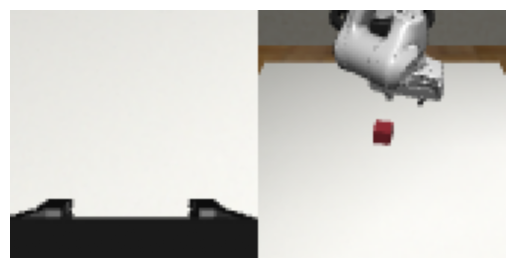

In [44]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from matplotlib.animation import FuncAnimation, ArtistAnimation


def visualize(observations1, observations2, file_name, every_frame=2):
    # only get alternate frames to reduce the processing time
    observations1 = observations1[::every_frame]
    observations2 = observations2[::every_frame]
    im = []
    for i in range(len(observations1)):
        agentview_image1 = observations1[i].squeeze(0).squeeze(0).cpu().detach().numpy()[1]
        agentview_image1 = np.transpose(agentview_image1, (1, 2, 0))
        
        agentview_image2 = observations2[i].squeeze(0).squeeze(0).cpu().detach().numpy()[1]
        agentview_image2 = np.transpose(agentview_image2, (1, 2, 0))
        
        combined_image = np.hstack((agentview_image1, agentview_image2))
        im.append(combined_image)

    fig, ax = plt.subplots()
    ims = []
    for i in range(len(im)):
        im_obj = ax.imshow(im[i], animated=True)
        ims.append([im_obj])
        ax.axis('off')

    ani = ArtistAnimation(fig, ims, interval=100, blit=True)
    ani.save(file_name, writer='pillow', fps=10)


# visualize(observation_robot0_eye_in_hand, observation_agentview, file_name = f'/teamspace/studios/this_studio/bc_attacks/diffusion_policy/plots/videos/adversarial_patch/no_red_patch_x_{x_loc}_y_{y_loc}_{patch_size}_rew_{rewards}.gif')
visualize(observation_robot0_eye_in_hand, observation_agentview, file_name = f'/teamspace/studios/this_studio/bc_attacks/diffusion_policy/plots/interpretability/no_red_block.gif')


In [14]:
from torch.utils.data import Dataset
class ObservationActionDataset(Dataset):
    def __init__(self, observations, actions):
        self.observations = observations
        self.actions = actions

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx):
        observation = self.observations[idx]
        action = self.actions[idx]
        return observation, action

In [15]:
import importlib
from diffusion_policy.policy import ibc_dfo_hybrid_image_policy
importlib.reload(ibc_dfo_hybrid_image_policy)

<module 'diffusion_policy.policy.ibc_dfo_hybrid_image_policy' from '/teamspace/studios/this_studio/bc_attacks/diffusion_policy/diffusion_policy/policy/ibc_dfo_hybrid_image_policy.py'>

In [24]:
# disable cudann
x_loc_trans, y_loc_trans = 0, 0
# torch.backends.cudnn.enabled = False
epsilon = 0.125
num_inner_iters = 400
# create a patch of size 24x24
def patch_attack(policy, train_loader, val_loader, patch_size, num_iterations=100):
    # create a universal patch of size 84x84
    universal_patch = torch.zeros((3, patch_size, patch_size), dtype=torch.float32)
    # clean_patch = patch.clone().detach().to(device)
    # patch = patch.to(device)
    # convert the patch to a parameter which can be optimized
    # patch = torch.nn.Parameter(patch)
    universal_patch = universal_patch.to(device)
    # convert the patch to a parameter which can be optimized
    universal_patch = torch.nn.Parameter(universal_patch)
    optimizer = torch.optim.Adam([universal_patch], lr=0.05)
    losses = []
    T_neg = policy.train_n_neg
    T_a = policy.n_action_steps
    naction_stats = policy.get_naction_stats()
    data_points = len(train_loader)
    for i in range(num_iterations):
        total_loss = 0
        with tqdm.tqdm(total=data_points, desc="Data Points") as pbar:
            for obs, target_action in train_loader:
                if target_action.dtype == torch.float64:
                    target_action = target_action.float().to(device)
                B = obs[view].shape[0]
                for key in obs.keys():
                    obs[key] = obs[key].squeeze(1)
                action_samples = torch.distributions.Uniform(
                    low=naction_stats['min'],
                    high=naction_stats['max']
                    ).sample((B, T_neg, T_a)).to(device=device)
                action_samples = torch.cat([target_action.unsqueeze(1), action_samples], dim=1)
                # replace one of the action with the clean action
                action_samples[:, 1] = target_action - torch.tensor(perturbations).to(device)
                # target_actions = torch.cat([torch.zeros_like(target_action[:,0:1]), target_action], dim=1)
                iter_loss = []
                for j in range(num_inner_iters):
                    perturbed_obs = copy.deepcopy(obs)
                    policy.reset()
                    perturbed_obs[view] = place_transparent_patch(perturbed_obs[view], universal_patch, location=(x_loc_trans, y_loc_trans))
                    perturbed_obs[view] = torch.clamp(perturbed_obs[view], 0, 1)
                    loss, _, obs_features, energies = policy.compute_loss_with_grad(perturbed_obs, target_action, action_samples, return_energy=True)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    # print(universal_patch.min(), universal_patch.max())
                    # Detach the patch from the graph to avoid retaining graph
                    # universal_patch = universal_patch.detach()
                    # clip the universal patch to be within the epsilon ball
                    # with torch.no_grad():
                    #    universal_patch = torch.clamp(universal_patch, -epsilon, epsilon)
                    # clip the observation to be within [0, 1]
                    iter_loss.append(loss.item())
                    total_loss += loss.item()
                # print(f'Min universal patch: {universal_patch.min()}, Max universal patch: {universal_patch.max()}, Average value of universal patch: {universal_patch.mean()}')
                pbar.update(1)
            # plot the iter_loss
            # plt.plot(iter_loss)
            # plt.xlabel('Inner Iterations')
            # plt.ylabel('Loss')
            # plt.title('Loss vs Inner Iterations')
            # plt.show()
            # if energies[0] > energies[1]:
            #     image = perturbed_obs[view].squeeze(0)[1].cpu().detach().numpy()
            #     image = np.transpose(image, (1, 2, 0))
            #     plt.imshow(image)
            #     plt.axis('off')
            #     plt.show()
        losses.append(total_loss)
            # print(universal_patch.min(), universal_patch.max())
        # print(f"Change in patch: {torch.norm(patch - clean_patch)}")
        if i % 100 == 0 and i != 0:
            print(f"Iteration: {i}, Loss: {total_loss}")
            # evaluate_patch(patch)
            # visualize the patch
            patch_np = universal_patch.cpu().detach().numpy()
            patch_np = np.transpose(patch_np, (1, 2, 0))
            plt.imshow(patch_np)
            plt.axis('off')
            plt.show()
    # plot the losses
    plt.plot(losses)
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Loss vs Iterations')
    plt.show()
    return universal_patch

# convert the obs_list and target_action_list to tensors as a dataset
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
# Split data into training and validation sets
obs_train, obs_val, action_train, action_val = train_test_split(obs_list, target_action_list, test_size=0.01, random_state=42)
# Create Dataset instances
train_dataset = ObservationActionDataset(obs_train, action_train)
val_dataset = ObservationActionDataset(obs_val, action_val)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# patch_sizes = [20, 24, 28, 32]
patch_sizes = [84]
for patch_size in patch_sizes:
    universal_patch = patch_attack(policy, train_loader, val_loader, patch_size, num_iterations=2)
    print(universal_patch.min(), universal_patch.max())
    # save the universal_patch as a numpy file
    universal_patch_np = universal_patch.cpu().detach().numpy()
    np.save(f'/teamspace/studios/this_studio/bc_attacks/diffusion_policy/plots/universal_patch/ibc_samesamiter10_universal_patch_transparent_y_60_50iters_eps_0.125.npy', universal_patch_np)
    # evaluate the patch
    rewards, observation_patch_agentview, observation_patch_robot0 = evaluate_patch(universal_patch, transparent=True)
    print(f"Reward: {rewards}")
    # visualize the observations
    file_name = f'/teamspace/studios/this_studio/bc_attacks/diffusion_policy/plots/videos/adversarial_patch/ibc_samesamiter10_trained_transparent_patch_perturbed_y60_x_{x_loc_trans}_y_{y_loc_trans}_{patch_size}_rew_{rewards}_eps0.125.gif'
    visualize(observation_patch_robot0, observation_patch_agentview, file_name = file_name)


Data Points:   0%|          | 0/594 [00:00<?, ?it/s]

Data Points:  81%|████████  | 479/594 [54:26<12:59,  6.78s/it] 

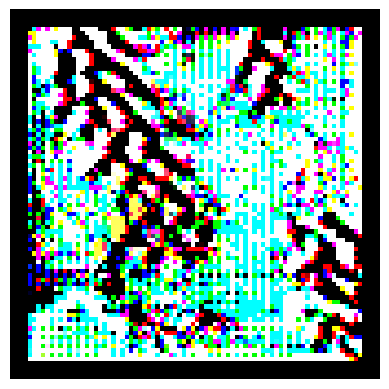

In [14]:
# visualize the universal patch
fig = plt.figure()
plt.imshow(universal_patch_np.transpose(1, 2, 0))
plt.axis('off')
plt.show()


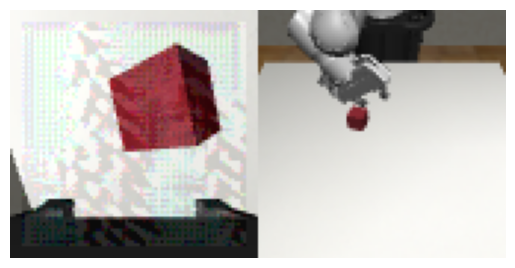

In [21]:
visualize(observation_patch_robot0, observation_patch_agentview, file_name = file_name)



============= Initialized Observation Utils with Obs Spec =============

using obs modality: low_dim with keys: ['robot0_gripper_qpos', 'robot0_eef_quat', 'robot0_eef_pos']
using obs modality: rgb with keys: ['agentview_image', 'robot0_eye_in_hand_image']
using obs modality: depth with keys: []
using obs modality: scan with keys: []


/home/zeus/miniconda3/envs/cloudspace/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_5782/3492069373.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs = dict_apply(obs, lambda x: torch.tensor(x).unsqueeze(0))
Timesteps:   0%|          | 0/400 [00:00<?, ?it/s]/tmp/ipykernel_5782/3492069373.py:34: UserWarning: To copy construct from a tensor, it is recommended

Patch is successful with reward: 0.0
Reward: 0.0


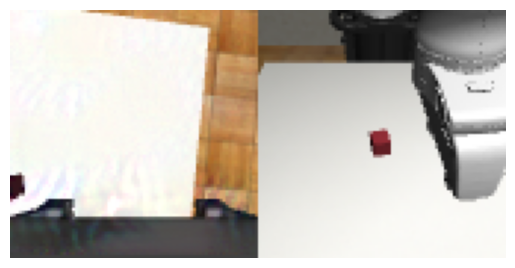

In [28]:
# load other checkpoints policy to check the performance of the patch
checkpoint = '/teamspace/studios/this_studio/bc_attacks/diffusion_policy/data/experiments/image/lift_ph/lstm_gmm/train_0/checkpoints/epoch=1100-test_mean_score=1.000.ckpt'
payload = torch.load(open(checkpoint, 'rb'), pickle_module=dill)
cfg_loaded = payload['cfg']
cls = hydra.utils.get_class(cfg_loaded._target_)
workspace = cls(cfg_loaded)
workspace.load_payload(payload, exclude_keys=None, include_keys=None)
policy = workspace.model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
policy.to(device)
policy.eval()

# evaluate the patch
rewards, observation_patch_agentview, observation_patch_robot0 = evaluate_patch(universal_patch, transparent=True)
print(f"Reward: {rewards}")
# visualize the observations
file_name = f'/teamspace/studios/this_studio/bc_attacks/diffusion_policy/plots/videos/adversarial_patch/trained0_transparent_patch_perturbed_y20_x_{x_loc_trans}_y_{y_loc_trans}_{patch_size}_rew_{rewards}.gif'
visualize(observation_patch_robot0, observation_patch_agentview, file_name = file_name)


In [48]:
print(universal_patch.min(), universal_patch.max())

tensor(-3.0544, device='cuda:0', grad_fn=<MinBackward1>) tensor(2.9877, device='cuda:0', grad_fn=<MaxBackward1>)


/tmp/ipykernel_31751/878138627.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs = dict_apply(obs, lambda x: torch.tensor(x).unsqueeze(0))
Timesteps:   0%|          | 0/400 [00:00<?, ?it/s]/tmp/ipykernel_31751/878138627.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs = dict_apply(obs, lambda x: torch.tensor(x).unsqueeze(0))
Timesteps: 100%|██████████| 400/400 [00:53<00:00,  7.46it/s]


Patch is successful with reward: 0.0
Reward: 0.0


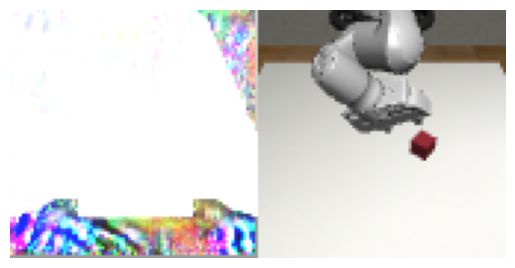

In [45]:
patch_size = 84
rewards, observation_patch_agentview, observation_patch_robot0 = evaluate_patch(universal_patch, transparent=True)
print(f"Reward: {rewards}")
# visualize the observations
file_name = f'/teamspace/studios/this_studio/bc_attacks/diffusion_policy/plots/videos/adversarial_patch/trained_transparent_patch_perturbed_y60_x_{x_loc_trans}_y_{y_loc_trans}_{patch_size}_rew_{rewards}.gif'
visualize(observation_patch_robot0, observation_patch_agentview, file_name = file_name)


In [31]:
# visualize how the patch looks like on the robot0_eye_in_hand_image
obs_robot0 = obs_list[0]
obs_robot0 = place_patch(obs_robot0, patch, location=(16, 16))
obs_robot0 = obs_robot0.squeeze(0).squeeze(0).cpu().detach().numpy()
obs_robot0 = np.transpose(obs_robot0, (1, 2, 0))
plt.imshow(obs_robot0)
plt.axis('off')
plt.show()


AttributeError: 'dict' object has no attribute 'shape'